# Personal Information
Name: **Mara Smeets**

StudentID: **14629747**

Email: [**mara.smeets@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **DD.MM.YYYY**

Deliverable: A PDF of your Jupyter notebook that has a minimal length of 3 pages and includes your 
GitHub link

https://github.com/Mara4444/MSc-thesis-2024


#### Import relevant packages

In [3]:
# Importshttps://file+.vscode-resource.vscode-cdn.net/c%3A/Users/maras/OneDrive/Documents/UvA/ml-icl/EDA/GSM8K_Reasoning_steps_Shi.png
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
import re
import statsmodels.api as sm
from scipy import stats

nltk.download('punkt')

%matplotlib inline



c:\Users\maras\anaconda3\envs\eda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Contents

1. Data context
2. The MGSM benchmark
3. Machine translation
4. Chain-of-thought experiments
5. The WALS dataset

# 1. Data Context
In this research, the base data sources are the MGSM benchmark (Shi et al., 2022) and the WALS dataset (Dryer et al., 2013). 

The MGSM benchmark is a multilingual grade-school math problem dataset. This benchmark is commonly used to test the performance of LLMs on arithmetic reasoning tasks. It consists of the first 250 examples from the GSM8K official test example list (Cobbe et al., 2021). The 250 math problems are human-translated into a typologically diverse set of 10 languages other than English: Bengali, Chinese, French, German, Japanese, Russian, Spanish, Swahili, Telugu, and Thai. The original English set of 250 math problems is also included in order to construct a baseline performance. The dataset is loaded via huggingface.

Furthermore, the World Atlas of Language Structures database (WALS) is used in order to determine a similarity metric between languages. This database consists of structural (e.g. phonological, grammatical and lexical) properties of languages.

# 2. The MGSM benchmark

#### Data loading

In [2]:
mgsm_en = load_dataset("juletxara/mgsm","en")        


In [3]:
gsm8k = load_dataset('gsm8k','main')

questions = gsm8k['test']['question']
answers = gsm8k['test']['answer']

gsm8k = pd.DataFrame(data = {'question' : questions[:250],
                             'answer' : answers[:250]})
gsm8k.head()

question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                              answer  
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...  
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...  
2  The cost of the house and repairs came out to ...  
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...  
4  If each chicken eats 3 cups of feed per day, t...

Moreover, the MGSM benchmark consists of 8 identical exemplars for each language that can be used in the few-shot setting. The English exemplars are shown below.

In [4]:
exemplars = pd.DataFrame(data={'question': mgsm_en['train']['question'],
                               'answer': mgsm_en['train']['answer']})
exemplars

question  \
0  Question: Roger has 5 tennis balls. He buys 2 ...   
1  Question: There were nine computers in the ser...   
2  Question: Leah had 32 chocolates and her siste...   
3  Question: Shawn has five toys. For Christmas, ...   
4  Question: Michael had 58 golf balls. On tuesda...   
5  Question: Olivia has $23. She bought five bage...   
6  Question: Jason had 20 lollipops. He gave Denn...   
7  Question: If there are 3 cars in the parking l...   

                                              answer  
0  Step-by-Step Answer: Roger started with 5 ball...  
1  Step-by-Step Answer: There are 4 days from mon...  
2  Step-by-Step Answer: Leah had 32 chocolates an...  
3  Step-by-Step Answer: He has 5 toys. He got 2 f...  
4  Step-by-Step Answer: Michael started with 58 g...  
5  Step-by-Step Answer: 5 bagels for $3 each shou...  
6  Step-by-Step Answer: Jason started with 20 lol...  
7  Step-by-Step Answer: There are 3 cars in the b...

The first 250 test questions of the GSM8K benchmark are included in order to explore complexity of the questions in the dataset. This is done by analyzing the main characteristics of the original questions and answer in the GSM8K dataset. The main characteristics that are evaluated are the length (i.e. number of characters), wordcount and the number of sentences. These features pose a basic overview of the complexity of the 250 questions in the dataset. Moreover, the Pearson's R correlation coefficient between the question and answer characteristics is evaluated.

**BESPREEK PLOT RESULTATEN HIER**

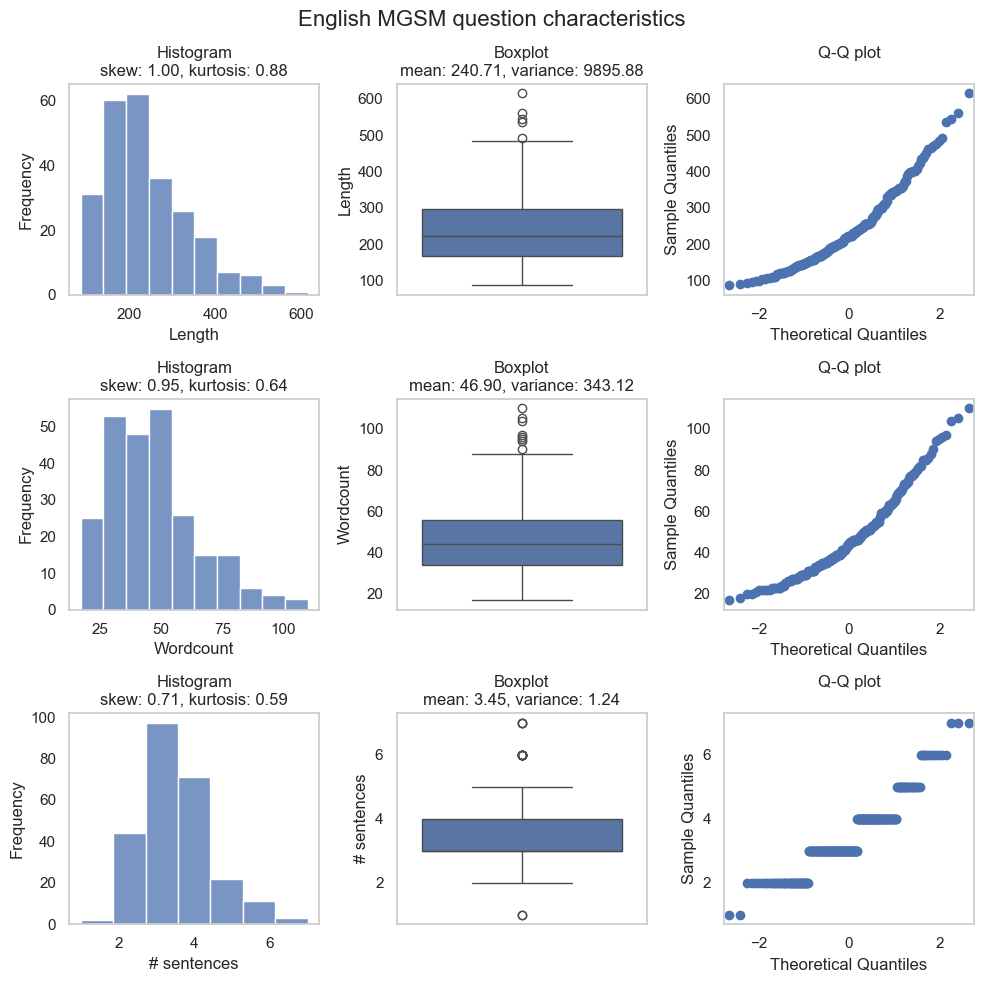

In [5]:
################## Data manipulation #####################

### Questions
length = []
wordcount = []
sentencecount = []  
    
for question in gsm8k["question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

gsm8k['Question length'] = length
gsm8k['Question wordcount'] = wordcount
gsm8k['Question nr_sentences'] = sentencecount

### Answers
length = []
wordcount = []
sentencecount = []

for answer in gsm8k["answer"]:
    length.append(len(answer))
    wordcount.append(len(answer.strip().split(" ")))
    sentences = sent_tokenize(answer)
    sentencecount.append(len(sentences))

gsm8k['Answer length'] = length
gsm8k['Answer wordcount'] = wordcount
gsm8k['Answer nr_sentences'] = sentencecount

################### Plotting #####################

# ### Questions
# plt.style.use('bmh')
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#     # Plot for 'length' column
# sns.histplot(gsm8k['Question length'], kde=False, bins=10, ax=axes[0])
# axes[0].set_xlabel('Length')
# for p in axes[0].patches:
#     axes[0].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

#     # Plot for 'wordcount' column
# sns.histplot(gsm8k['Question wordcount'], kde=False, bins=10, ax=axes[1])
# axes[1].set_xlabel('Word count')
# for p in axes[1].patches:
#     axes[1].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

#     # Plot for 'nr_sentences' column
# sns.histplot(gsm8k['Question nr_sentences'], kde=False, bins=6, ax=axes[2])
# axes[2].set_xlabel('# sentences')
# axes[2].set_xticks(np.arange(1,9,1))
# for p in axes[2].patches:
#     axes[2].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# fig.suptitle('Distribution of question characteristics in the first 250 questions of the GSM8K dataset', fontsize=16)
# plt.tight_layout()
# plt.show()

# ### Answers
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#     # Plot for 'length' column
# sns.histplot(gsm8k['Answer length'], kde=False, bins=10, ax=axes[0])
# axes[0].set_xlabel('Length')
# for p in axes[0].patches:
#     axes[0].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

#     # Plot for 'wordcount' column
# sns.histplot(gsm8k['Answer wordcount'], kde=False, bins=10, ax=axes[1])
# axes[1].set_xlabel('Word count')
# for p in axes[1].patches:
#     axes[1].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

#     # Plot for 'nr_sentences' column
# sns.histplot(gsm8k['Answer nr_sentences'], kde=False, bins=6, ax=axes[2])
# axes[2].set_xlabel('# sentences')
# axes[2].set_xticks(np.arange(1,9,1))
# for p in axes[2].patches:
#     axes[2].annotate(f'{p.get_height():.0f}\n',
#                      (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# fig.suptitle('Distribution of answer characteristics in the first 250 questions of the GSM8K dataset', fontsize=16)
# plt.tight_layout()
# plt.show()

# ### Correlation plots   
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#     # Plot for 'length' column
# sns.scatterplot(x=gsm8k['Question length'],y=gsm8k['Answer length'], ax=axes[0])
# sns.regplot(x=gsm8k['Question length'], y=gsm8k['Answer length'], ax=axes[0], scatter=False, color='red')
# correlation = gsm8k['Question length'].corr(gsm8k['Answer length'])
# axes[0].set_title('Length')
# axes[0].set_xlabel('Question')
# axes[0].set_ylabel('Answer')
# axes[0].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')

#     # Plot for 'wordcount' column
# sns.scatterplot(x=gsm8k['Question wordcount'],y=gsm8k['Answer wordcount'], ax=axes[1])
# sns.regplot(x=gsm8k['Question wordcount'], y=gsm8k['Answer wordcount'], ax=axes[1], scatter=False, color='red')
# correlation = gsm8k['Question wordcount'].corr(gsm8k['Answer wordcount'])
# axes[1].set_title('Wordcount')
# axes[1].set_xlabel('Question')
# axes[1].set_ylabel('Answer')
# axes[1].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')


#     # Plot for 'nr_sentences' column
# sns.scatterplot(x=gsm8k['Question nr_sentences'],y=gsm8k['Answer nr_sentences'],ax=axes[2])
# sns.regplot(x=gsm8k['Question nr_sentences'], y=gsm8k['Answer nr_sentences'], ax=axes[2], scatter=False, color='red')
# correlation = gsm8k['Question nr_sentences'].corr(gsm8k['Answer nr_sentences'])
# axes[2].set_title('# of sentences')
# axes[2].set_xlabel('Question')
# axes[2].set_ylabel('Answer')
# axes[2].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')

# fig.suptitle('Scatterplot between question and answer characteristics in the first 250 questions of the GSM8K dataset', fontsize=16)
# plt.tight_layout()
# plt.show()

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

### Question length

    # Histogram
sns.histplot(gsm8k['Question length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {gsm8k['Question length'].skew():.2f}, kurtosis: {gsm8k['Question length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Question length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {gsm8k['Question length'].mean():.2f}, variance: {gsm8k['Question length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Question length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Question wordcount

    # Histogram
sns.histplot(gsm8k['Question wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {gsm8k['Question wordcount'].skew():.2f}, kurtosis: {gsm8k['Question wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Question wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {gsm8k['Question wordcount'].mean():.2f}, variance: {gsm8k['Question wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Question wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

### Question nr sentences

    # Histogram
sns.histplot(gsm8k['Question nr_sentences'], kde=False, bins=7, ax=axes[2,0])
axes[2,0].set_title(f'Histogram\nskew: {gsm8k['Question nr_sentences'].skew():.2f}, kurtosis: {gsm8k['Question nr_sentences'].kurtosis():.2f}')
axes[2,0].set_xlabel('# sentences')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Question nr_sentences'], ax=axes[2,1])
axes[2,1].set_title(f'Boxplot\nmean: {gsm8k['Question nr_sentences'].mean():.2f}, variance: {gsm8k['Question nr_sentences'].var():.2f}')
axes[2,1].set_ylabel('# sentences')
axes[2,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Question nr_sentences'],ax=axes[2,2])
axes[2,2].set_title('Q-Q plot\n')
axes[2,2].grid(False)

fig.suptitle('English MGSM question characteristics', fontsize=16)
plt.tight_layout()
plt.show()

For the answers specifically we count the number of mathematical operators (i.e. +, -, /, *).

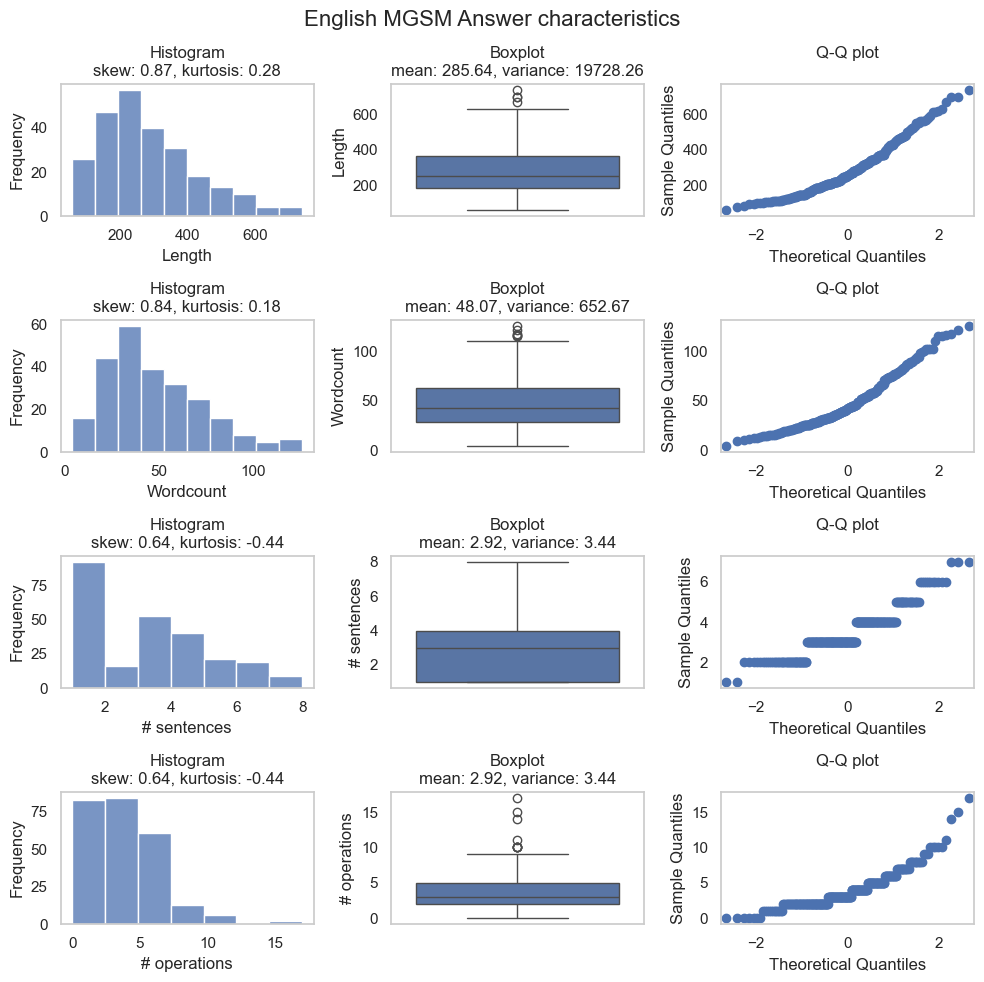

In [6]:
# count number of mathematical operations
plus_countlist = []
min_countlist = []
div_countlist = []
mult_countlist = []

for answer in gsm8k['answer']:
    # first remove the operation parts between << >> 
    pattern = r'<<.*?>>'
    answer = re.sub(pattern, '', answer)
    
    # then count the number of math operations in each answer
    plus_count = 0
    min_count = 0
    div_count = 0
    mult_count = 0
    for i in answer:
        if i == '+':
            plus_count += 1
        elif i == '-':
            min_count += 1
        elif i == '/':
            div_count +=1
        elif i == '*':
            mult_count += 1
    plus_countlist.append(plus_count)
    min_countlist.append(min_count)
    div_countlist.append(div_count)
    mult_countlist.append(mult_count)

gsm8k['Plus'] = plus_countlist
gsm8k['Min'] = min_countlist
gsm8k['Divisions'] = div_countlist
gsm8k['Multiplications'] = mult_countlist
gsm8k['Nr_operations'] = gsm8k[['Plus', 'Min', 'Divisions','Multiplications']].sum(axis=1)

# plt.figure(figsize=(5, 5))
# sns.histplot(gsm8k['Nr_operations'], kde=False, bins=10)
# plt.title('Distribution of the nr of operations in the answers')
# plt.xlabel('# operations')
# plt.xticks(np.arange(0,18,2))

# counts, bin_edges = np.histogram(gsm8k['Nr_operations'], bins=10)
# for i in range(len(counts)):
#     plt.annotate(str(counts[i]), xy=((bin_edges[i] + bin_edges[i+1]) / 2, counts[i]), xytext=(0, 5),
#                  textcoords='offset points', ha='center', va='bottom',color='crimson')
    
# plt.tight_layout()
# plt.show()

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

### Answer length

    # Histogram
sns.histplot(gsm8k['Answer length'], kde=False, bins=10, ax=axes[0,0])
axes[0,0].set_title(f'Histogram\nskew: {gsm8k['Answer length'].skew():.2f}, kurtosis: {gsm8k['Answer length'].kurtosis():.2f}')
axes[0,0].set_xlabel('Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Answer length'], ax=axes[0,1])
axes[0,1].set_title(f'Boxplot\nmean: {gsm8k['Answer length'].mean():.2f}, variance: {gsm8k['Answer length'].var():.2f}')
axes[0,1].set_ylabel('Length')
axes[0,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Answer length'],ax=axes[0,2])
axes[0,2].set_title('Q-Q plot\n')
axes[0,2].grid(False)

### Answer wordcount

    # Histogram
sns.histplot(gsm8k['Answer wordcount'], kde=False, bins=10, ax=axes[1,0])
axes[1,0].set_title(f'Histogram\nskew: {gsm8k['Answer wordcount'].skew():.2f}, kurtosis: {gsm8k['Answer wordcount'].kurtosis():.2f}')
axes[1,0].set_xlabel('Wordcount')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Answer wordcount'], ax=axes[1,1])
axes[1,1].set_title(f'Boxplot\nmean: {gsm8k['Answer wordcount'].mean():.2f}, variance: {gsm8k['Answer wordcount'].var():.2f}')
axes[1,1].set_ylabel('Wordcount')
axes[1,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Answer wordcount'],ax=axes[1,2])
axes[1,2].set_title('Q-Q plot\n')
axes[1,2].grid(False)

### Answer nr sentences

    # Histogram
sns.histplot(gsm8k['Answer nr_sentences'], kde=False, bins=7, ax=axes[2,0])
axes[2,0].set_title(f'Histogram\nskew: {gsm8k['Answer nr_sentences'].skew():.2f}, kurtosis: {gsm8k['Answer nr_sentences'].kurtosis():.2f}')
axes[2,0].set_xlabel('# sentences')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Answer nr_sentences'], ax=axes[2,1])
axes[2,1].set_title(f'Boxplot\nmean: {gsm8k['Answer nr_sentences'].mean():.2f}, variance: {gsm8k['Answer nr_sentences'].var():.2f}')
axes[2,1].set_ylabel('# sentences')
axes[2,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Question nr_sentences'],ax=axes[2,2])
axes[2,2].set_title('Q-Q plot\n')
axes[2,2].grid(False)

### Answer nr operations

    # Histogram
sns.histplot(gsm8k['Nr_operations'], kde=False, bins=7, ax=axes[3,0])
axes[3,0].set_title(f'Histogram\nskew: {gsm8k['Answer nr_sentences'].skew():.2f}, kurtosis: {gsm8k['Answer nr_sentences'].kurtosis():.2f}')
axes[3,0].set_xlabel('# operations')
axes[3,0].set_ylabel('Frequency')
axes[3,0].grid(False)

    # Boxplot
sns.boxplot(gsm8k['Nr_operations'], ax=axes[3,1])
axes[3,1].set_title(f'Boxplot\nmean: {gsm8k['Answer nr_sentences'].mean():.2f}, variance: {gsm8k['Answer nr_sentences'].var():.2f}')
axes[3,1].set_ylabel('# operations')
axes[3,1].grid(False)

    # QQ plot
sm.qqplot(gsm8k['Nr_operations'],ax=axes[3,2])
axes[3,2].set_title('Q-Q plot\n')
axes[3,2].grid(False)

fig.suptitle('English MGSM Answer characteristics', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Machine translation

The MGSM benchmark is translated into other languages in order to perform relevant experiments. The NLLB-200-3.3B model is used to perform the machine translations (Costa et al., 2022). As translations from English show the best performance, the English MGSM benchmark is machine translated into the other languages in the targeted list. 

The aim is to experiment on a diverse language set based on language characteristics and with different representations in the Llama-2 pretraining corpus. The main demands for the languages to include are that they occur in the pretraining corpus of Llama-2 and that they are available in the NLLB-200 model for translation. 
<!-- A set of 7 languages other than English is selected for the experiments. The languages that are available in the original MGSM benchmark and do not need to be machine-translated are indicated with an \*. The experimental language set is: Catalan, Chinese\*, French\*, Indonesian, Portuguese, Spanish\* and Vietnamese. The distribution of the target languages in the pretraining corpus of both models is shown in table  -->

In [4]:
llama_lang = ['bul_Cyrl','cat_Latn','ces_Latn','dan_Latn','deu_Latn', 'eng_Latn', 'fin_Latn','fre_Latn','hrv_Latn','hun_Latn','ind_Latn','ita_Latn','jpn_Japn','kor_Hang','nld_Latn','nno_Latn','pol_Latn','por_Latn','ron_Latn','rus_Cyrl','slv_Latn','spa_Latn','srp_Cyrl','swe_Latn','ukr_Cyrl','vie_Latn','zho_Hant']

print('# languages:',len(llama_lang))

# languages: 27


The ChrF++ score is used as a metric for machine translation quality. The NLLB language name and language script are retrieved from the FLORES-200 language codes and is merged with the ChrF++ data (Costa et al., 2022). 

In [5]:
# load the languages dataset
nllb_lang = pd.read_csv('nllb_languages.csv', sep=';') 

# load the chrf++ metric dataset
nllb_metrics = pd.read_csv('./nllb_metrics.csv', sep=',')

# extract script data for each language
nllb_lang['Script'] = nllb_lang['FLORES-200 code'].str[-4:]

# select only the metrics where English is the source language
nllb_metrics = nllb_metrics[nllb_metrics['direction'].str[:3] == 'eng']

# add column trg_lang and merge with nllb dataframe
nllb_metrics['trg_lang'] = nllb_metrics['direction'].str[9:]
nllb_lang = pd.merge(nllb_lang,nllb_metrics,left_on='FLORES-200 code', right_on = 'trg_lang')
nllb_lang.drop(columns=['trg_lang'], inplace=True)
nllb_lang.drop(columns=['direction'], inplace=True)

# insert row for English
nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]

nllb_lang.head()


C:\Users\maras\AppData\Local\Temp\ipykernel_1860\1888822860.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]


Language FLORES-200 code Script  chrf++
0  Acehnese (Arabic script)        ace_Arab   Arab    19.7
1   Acehnese (Latin script)        ace_Latn   Latn    37.4
2       Mesopotamian Arabic        acm_Arab   Arab    38.4
3      Ta’izzi-Adeni Arabic        acq_Arab   Arab    45.1
4           Tunisian Arabic        aeb_Arab   Arab    34.6

The Llama-2-7b-chat model is used for the chain-of-thought (CoT) experiments (Touvron et al., 2023). The languages that are included in this research are all languages in the pretraining corpus of the Llama-2 model. The distribution of the languages in the pretraining corpus is retrieved from the paper.

![image](Llama-2-languages..png)

Moreover, the ChrF++ score for each language that is included in the experiments is plotted. The languages that are already included in the MGSM benchmark are indicated in dark blue.

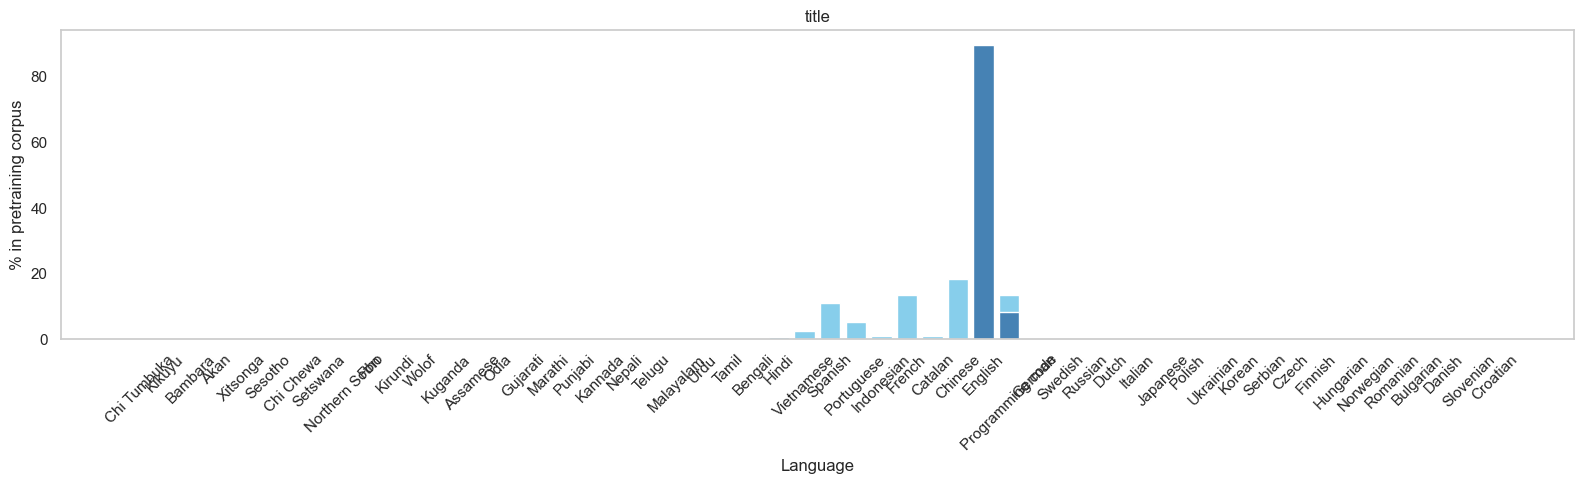

In [23]:
corpus = pd.read_csv('./training_corpus_llm.csv',sep=';')

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 5))
plt.bar(height=corpus['% in Bloomz-7b'], x=corpus['Language'],color='skyblue')
plt.bar(height=corpus['% in Llama-2-7b'], x=corpus['Language'],color='steelblue')

plt.title("title")
plt.ylabel("% in pretraining corpus")
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.grid(False)

plt.tight_layout()
plt.show()

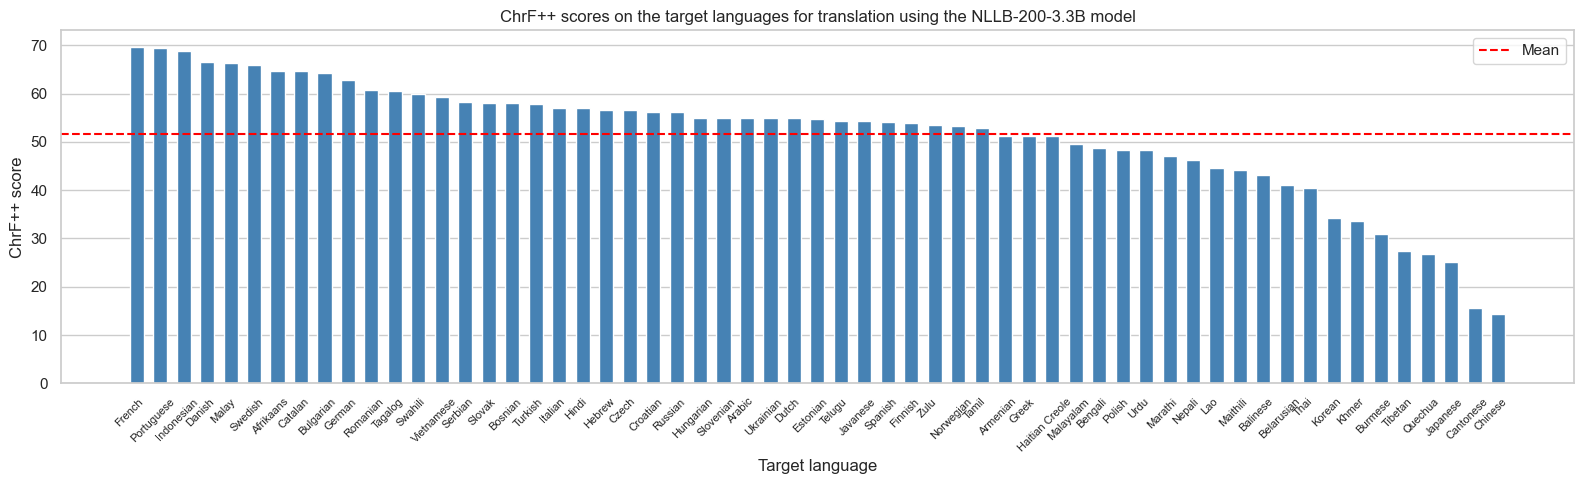

Mean ChrF++:  51.61186440677967


In [14]:
# Language set
llama_lang_nllb = ["Bulgarian","Catalan","Czech","Croatian","Danish", "Dutch","German","English","Finnish","French","Serbian","Hungarian", "Indonesian", "Italian","Japanese","Korean","Norwegian Nynorsk","Polish","Portuguese","Russian", "Spanish","Swedish","Romanian","Slovenian",'Thai',"Vietnamese","Chinese (Traditional)","Ukrainian"]
test_lang = ["afr_Latn","arb_Arab","ban_Latn","bel_Cyrl","ben_Beng","bod_Tibt", "bos_Latn","bul_Cyrl",
"ces_Latn", "cat_Latn","dan_Latn", "deu_Latn","ell_Grek","est_Latn", 
"fin_Latn", "fra_Latn","hat_Latn", "heb_Hebr","hin_Deva","hun_Latn", "hrv_Latn", "hye_Armn", 
"ind_Latn", "ita_Latn","jav_Latn", "jpn_Jpan","khm_Khmr","kor_Hang", 
"lao_Laoo","mai_Deva", "mal_Mlym", "mar_Deva", "mya_Mymr", "nno_Latn",
"nld_Latn", "npi_Deva","pol_Latn","por_Latn", "slk_Latn","quy_Latn","ron_Latn", "rus_Cyrl", 
"slv_Latn", "spa_Latn", "srp_Cyrl", "swe_Latn", "swh_Latn", "tam_Taml", "tel_Telu", 
"tgl_Latn", 'tha_Thai',"tur_Latn","ukr_Cyrl", "urd_Arab", "vie_Latn" , 'yue_Hant', "zho_Hant", "zsm_Latn","zul_Latn"]
nllb_chrf = nllb_lang.loc[nllb_lang['FLORES-200 code'].isin(test_lang)]

# sort chrf++ values
nllb_chrf_sorted = nllb_chrf.sort_values(by='chrf++', ascending=False)

# drop irrelevant row for English language
nllb_chrf_sorted = nllb_chrf_sorted.drop(nllb_chrf_sorted[nllb_chrf_sorted['Language'] == 'English'].index)

# rename language name
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Chinese (Traditional)", 'Language'] = 'Chinese'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Norwegian Nynorsk", 'Language'] = 'Norwegian'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Yue Chinese", 'Language'] = 'Cantonese'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Standard Malay", 'Language'] = 'Malay'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Standard Tibetan", 'Language'] = 'Tibetan'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Modern Standard Arabic", 'Language'] = 'Arabic'
nllb_chrf_sorted.loc[nllb_chrf_sorted['Language'] == "Ayacucho Quechua", 'Language'] = 'Quechua'

# extract mean chrf++ value
mean_chrf = np.mean(nllb_chrf['chrf++'])

plt.figure(figsize=(16, 5))
sns.set_theme(style="whitegrid")
bars = plt.bar(nllb_chrf_sorted['Language'], nllb_chrf_sorted['chrf++'], color='steelblue', width=0.6, align='edge')

# Add a horizontal line for mean
plt.axhline(y=mean_chrf, color='red', linestyle='--', label='Mean')  

 # Add the mgsm languages to label in darker blue
# labels = ['French', 'Swahili', 'Russian', 'Chinese', 'Japanese', 'Telugu', 'Bengali', 'Spanish', 'German', 'Thai'] 
labels = [
    "Afrikaans", "Arabic", "Armenian", "Balinese", "Belarussian", "Bengali", 
    "Bosnian", "Bulgarian", "Burmese", "Cantonese", "Catalan", "Chinese", 
    "Croatian", "Czech", "Danish", "Dutch", "Estonian", "Finnish", "French", 
    "German", "Greek", "Haitian Creole", "Hebrew", "Hindi", "Hungarian", "Indonesian", "Italian", 
    "Javanese", "Japanese", "Khmer", "Korean", "Lao", "Maithili", "Malay", "Malayam",
    "Marathi", "Nepali", "Norwegian", "Polish", "Portuguese", "Quechua", 
    "Romanian", "Russian", "Serbian", "Slovak", "Slovenian", "Spanish", 
    "Swahili", "Swedish", "Tagalog", "Tamil", "Telugu", "Thai", "Tibetan", 
    "Turkish", "Ukrainian", "Urdu",  "Vietnamese", "Zulu"
]
# for bar, label in zip(bars, nllb_chrf_sorted['Language']):
#     if label in labels:
#         bar.set_color('steelblue')

plt.xlabel('Target language')
plt.ylabel('ChrF++ score')
plt.title('ChrF++ scores on the target languages for translation using the NLLB-200-3.3B model')
plt.xticks(rotation=45, fontsize=8)
plt.grid(False, axis='x')
plt.legend()
plt.tight_layout()  
plt.show()

print('Mean ChrF++: ', mean_chrf)

The 250 English MGSM test questions are translated into all relevant languages in the test set.

In [12]:
language_codes = {'Bulgarian': 'bul_Cyrl',
                  'Catalan': 'cat_Latn',
                  'Chinese' : 'zho_Hant',
                  'Croatian': 'hrv_Latn',
                  'Czech': 'ces_Latn',
                  'Danish': 'dan_Latn',
                  'Dutch': 'nld_Latn',
                  'English': 'eng_Latn',
                  'Finnish': 'fin_Latn',
                  'French' : 'fre_Latn',
                  'German' : 'deu_Latn',
                  'Hungarian': 'hun_Latn',
                  'Indonesian': 'ind_Latn',
                  'Italian': 'ita_Latn',
                  'Japanese' : 'Jpan',
                  'Korean': 'kor_Hang',
                  'Norwegian': 'nno_Latn',
                  'Polish': 'pol_Latn',
                  'Portuguese': 'por_Latn',
                  'Romanian': 'ron_Latn',
                  'Russian' : 'rus_Cyrl',
                  'Slovenian': 'slv_Latn',
                  'Spanish' : 'spa_Latn',
                  'Serbian': 'srp_Cyrl',
                  'Swedish': 'swe_Latn',
                  'Ukrainian': 'ukr_Cyrl',
                  'Vietnamese': 'vie_Latn'}

def get_translated_dataset_df(name,lang):
    """
    Loads a translated dataset from the directory in the requested language.
    
    Parameters:
    name: name of the dataset ['mgsm', 'xcopa', 'xstorycloze', 'mkqa', 'pawsx', 'xnli' or 'xlsum']
    lang: language of the dataset to load.
    
    Returns:
    Dataset in the specified language as dataframe
    """
    lang = language_codes[lang]

    if name == "mgsm":
        df = pd.read_csv('../datasets/mgsm/mgsm_' + lang + '.csv',sep=';') 
        
        return df
    
    else:
        print("Dataset name is not correctly specified. Please input 'mgsm'.")

### Data loading

In [13]:
# original datasets from huggingface
mgsm_bn = load_dataset("juletxara/mgsm","bn")     
mgsm_de = load_dataset("juletxara/mgsm","de")     
mgsm_es = load_dataset("juletxara/mgsm","es")     
mgsm_fr = load_dataset("juletxara/mgsm","fr")     
mgsm_ja = load_dataset("juletxara/mgsm","ja")     
mgsm_ru = load_dataset("juletxara/mgsm","ru")     
mgsm_sw = load_dataset("juletxara/mgsm","sw")     
mgsm_te = load_dataset("juletxara/mgsm","te")     
mgsm_th = load_dataset("juletxara/mgsm","th")     
mgsm_zh = load_dataset("juletxara/mgsm","zh")     

# translated datasets
mgsm_bu = get_translated_dataset_df("mgsm","Bulgarian")
mgsm_ca = get_translated_dataset_df("mgsm","Catalan")
mgsm_cz = get_translated_dataset_df("mgsm","Czech")
mgsm_cr = get_translated_dataset_df("mgsm","Croatian")
mgsm_dn = get_translated_dataset_df("mgsm","Danish")
mgsm_du = get_translated_dataset_df("mgsm","Dutch")
mgsm_fi = get_translated_dataset_df("mgsm","Finnish")
mgsm_se = get_translated_dataset_df("mgsm","Serbian")
mgsm_hu = get_translated_dataset_df("mgsm","Hungarian")
mgsm_in = get_translated_dataset_df("mgsm","Indonesian")
mgsm_it = get_translated_dataset_df("mgsm","Italian")
mgsm_ko = get_translated_dataset_df("mgsm","Korean")
mgsm_no = get_translated_dataset_df("mgsm","Norwegian")
mgsm_pl = get_translated_dataset_df("mgsm","Polish")
mgsm_sd = get_translated_dataset_df("mgsm","Swedish")
mgsm_po = get_translated_dataset_df("mgsm","Portuguese")
mgsm_ro = get_translated_dataset_df("mgsm","Romanian")
mgsm_sl = get_translated_dataset_df("mgsm","Slovenian")
mgsm_vi = get_translated_dataset_df("mgsm","Vietnamese")
mgsm_uk = get_translated_dataset_df("mgsm","Ukrainian")

The mean of the main characters is extracted for each language in the language set. This is visualizes in a boxplot to identify possible outliers.

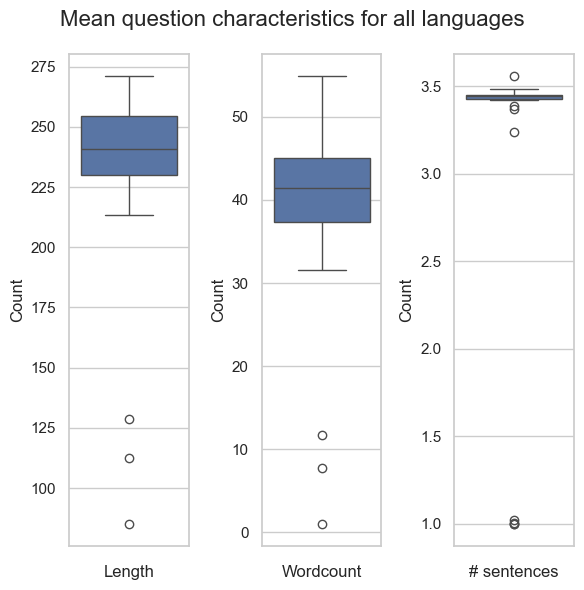

In [14]:
data = {'Language' : ["English"]*250+["Bengali"]*250 + ["German"]*250 + ["Spanish"]*250 + ["French"]*250 + ["Japanese"]*250 + ["Russian"]*250 + ["Swahili"]*250 + ["Telugu"]*250 + ["Thai"]*250 + ["Chinese"]*250 + ["Bulgarian"]*250 + ["Catalan"]*250 + ["Czech"]*250 + ["Croatian"]*250 + ["Danish"]*250 + ["Dutch"]*250 + ["Finnish"]*250 + ["Serbian"]*250 + ["Hungarian"]*250 + ["Indonesian"]*250 + ["Italian"]*250 + ["Korean"]*250 + ["Norwegian"]*250 + ["Polish"]*250 + ["Portuguese"]*250 + ["Swedish"]*250 + ["Romanian"]*250 + ["Slovenian"]*250 + ["Vietnamese"]*250 + ["Ukrainian"]*250,
        'Question': mgsm_en["test"]["question"] + mgsm_bn["test"]["question"] + mgsm_de["test"]["question"] + mgsm_es["test"]["question"] + mgsm_fr["test"]["question"] + mgsm_ja["test"]["question"] + mgsm_ru["test"]["question"] + mgsm_sw["test"]["question"] + mgsm_te["test"]["question"] + mgsm_th["test"]["question"] + mgsm_zh["test"]["question"] + mgsm_bu['question'].tolist() + mgsm_ca['question'].tolist() +mgsm_cz['question'].tolist() + mgsm_cr['question'].tolist()+ mgsm_dn['question'].tolist() + mgsm_du['question'].tolist() + mgsm_fi['question'].tolist() + mgsm_se['question'].tolist() + mgsm_hu['question'].tolist() + mgsm_in['question'].tolist() + mgsm_it['question'].tolist() + mgsm_ko['question'].tolist() + mgsm_no['question'].tolist() + mgsm_pl['question'].tolist() + mgsm_po['question'].tolist() + mgsm_sd['question'].tolist() + mgsm_ro['question'].tolist() + mgsm_sl['question'].tolist() + mgsm_vi['question'].tolist() + mgsm_uk['question'].tolist()
        }
df = pd.DataFrame(data=data)

length = []
wordcount = []
sentencecount = []
    
for question in df["Question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

df['Length'] = length
df['Wordcount'] = wordcount
df['Nr_sentences'] = sentencecount

df = df.groupby('Language')[['Length', 'Wordcount', 'Nr_sentences']].mean()
df

### Boxplots   
fig, axes = plt.subplots(1, 3, figsize=(6, 6))

    # Plot for 'length' column
sns.boxplot(df['Length'], ax=axes[0])
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')

    # Plot for 'word count' column
sns.boxplot(df['Wordcount'], ax=axes[1])
axes[1].set_xlabel('Wordcount')
axes[1].set_ylabel('Count')

    # Plot for 'nr_sentences' column
sns.boxplot(df['Nr_sentences'], ax=axes[2])
axes[2].set_xlabel('# sentences')
axes[2].set_ylabel('Count')

fig.suptitle('Mean question characteristics for all languages', fontsize=16)
plt.tight_layout()
plt.show()

# sns.set_theme(style="whitegrid")
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# ### Question length

#     # Histogram
# sns.histplot(df['Length'], kde=False, bins=10, ax=axes[0,0])
# axes[0,0].set_title(f'Histogram\nskew: {df['Length'].skew():.2f}, kurtosis: {df['Length'].kurtosis():.2f}')
# axes[0,0].set_xlabel('Length')
# axes[0,0].set_ylabel('Frequency')
# axes[0,0].grid(False)

#     # Boxplot
# sns.boxplot(df['Length'], ax=axes[0,1])
# axes[0,1].set_title(f'Boxplot\nmean: {df['Length'].mean():.2f}, variance: {df['Length'].var():.2f}')
# axes[0,1].set_ylabel('Length')
# axes[0,1].grid(False)

#     # QQ plot
# sm.qqplot(df['Length'],ax=axes[0,2])
# axes[0,2].set_title('Q-Q plot\n')
# axes[0,2].grid(False)

# ### Question wordcount

#     # Histogram
# sns.histplot(df['Wordcount'], kde=False, bins=10, ax=axes[1,0])
# axes[1,0].set_title(f'Histogram\nskew: {df['Wordcount'].skew():.2f}, kurtosis: {df['Wordcount'].kurtosis():.2f}')
# axes[1,0].set_xlabel('Wordcount')
# axes[1,0].set_ylabel('Frequency')
# axes[1,0].grid(False)

#     # Boxplot
# sns.boxplot(df['Wordcount'], ax=axes[1,1])
# axes[1,1].set_title(f'Boxplot\nmean: {df['Wordcount'].mean():.2f}, variance: {df['Wordcount'].var():.2f}')
# axes[1,1].set_ylabel('Wordcount')
# axes[1,1].grid(False)

#     # QQ plot
# sm.qqplot(df['Wordcount'],ax=axes[1,2])
# axes[1,2].set_title('Q-Q plot\n')
# axes[1,2].grid(False)

# ### Question nr sentences

#     # Histogram
# sns.histplot(df['Nr_sentences'], kde=False, bins=7, ax=axes[2,0])
# axes[2,0].set_title(f'Histogram\nskew: {df['Nr_sentences'].skew():.2f}, kurtosis: {df['Nr_sentences'].kurtosis():.2f}')
# axes[2,0].set_xlabel('# sentences')
# axes[2,0].set_ylabel('Frequency')
# axes[2,0].grid(False)

#     # Boxplot
# sns.boxplot(df['Nr_sentences'], ax=axes[2,1])
# axes[2,1].set_title(f'Boxplot\nmean: {df['Nr_sentences'].mean():.2f}, variance: {df['Nr_sentences'].var():.2f}')
# axes[2,1].set_ylabel('# sentences')
# axes[2,1].grid(False)

#     # QQ plot
# sm.qqplot(df['Nr_sentences'],ax=axes[2,2])
# axes[2,2].set_title('Q-Q plot\n')
# axes[2,2].grid(False)

# fig.suptitle('Mean MGSM question characteristics for all languages', fontsize=16)
# plt.tight_layout()
# plt.show()


In [15]:
df = df.sort_values(by='Length', ascending=True)
print(df['Length'].head(3))

df = df.sort_values(by='Wordcount', ascending=True)
print(df['Wordcount'].head(3))

df = df.sort_values(by='Nr_sentences', ascending=True)
print(df['Nr_sentences'].head(4))

Language
Chinese      85.156
Japanese    112.328
Korean      128.564
Name: Length, dtype: float64
Language
Japanese     1.032
Chinese      7.772
Thai        11.684
Name: Wordcount, dtype: float64
Language
Japanese    1.000
Chinese     1.000
Bengali     1.004
Thai        1.024
Name: Nr_sentences, dtype: float64


Explain about shortcoming of nllb-200 with short sentences for exemplars, and how we fix this.

# 4. WALS data

The WALS dataset is used as data source to quantify language similarity (Dryer et al., 2013).

#### Data loading

In [54]:
walsdata = pd.read_csv('../datasets/wals/language.csv', sep=',')

#### Data cleaning

First, we select only the languages in the walsdata set that are included in our experiment. The total dataset shows 27 languages and 202 columns.

In [55]:
llama_lang_wals = ["bul","ctl","cze","dsh", "dut","ger","eng","fin","fre","scr","hun", "ind", "ita","jpn","kor","nor","pol","por","rus", "spa","swe","rom","slo",'tha',"vie","mnd","ukr"]
walsdata_test = walsdata.loc[walsdata['wals_code'].isin(llama_lang_wals)]

walsdata_test.shape

(27, 202)

The NLLB data is merged into the WALS dataset. The language names that differ between the datasets are manually changed.

In [56]:
# change merge column name
nllb_lang.rename(columns = {'Language':'Name'}, inplace = True) 

# Change names that differ in the nllb language name and wals language name
nllb_lang.loc[nllb_lang['Name'] == 'Norwegian Nynorsk', 'Name'] = 'Norwegian'
nllb_lang.loc[nllb_lang['Name'] == 'Serbian', 'Name'] = 'Serbian-Croatian'
nllb_lang.loc[nllb_lang['Name'] == 'Slovenian', 'Name'] = 'Slovene'
nllb_lang.loc[nllb_lang['Name'] == 'Chinese (Traditional)', 'Name'] = 'Mandarin'
# nllb_lang.loc[nllb_lang['Name'] == 'Standard Malay', 'Name'] = 'Malay'
# nllb_lang.loc[nllb_lang['Name'] == 'Modern Standard Arabic', 'Name'] = 'Arabic (Modern Standard)'
# nllb_lang.loc[nllb_lang['Name'] == 'Belarusian', 'Name'] = 'Belorussian'
# nllb_lang.loc[nllb_lang['Name'] == 'Yue Chinese', 'Name'] = 'Cantonese'
# nllb_lang.loc[nllb_lang['Name'] == 'Greek', 'Name'] = 'Greek (Modern)'
# nllb_lang.loc[nllb_lang['Name'] == 'Hebrew', 'Name'] = 'Hebrew (Modern)'
# nllb_lang.loc[nllb_lang['Name'] == 'Ayacucho Quechua', 'Name'] = 'Quechan'
# nllb_lang.loc[nllb_lang['Name'] == 'Standard Tibetan', 'Name'] = 'Tibetan (Standard Spoken)'

# merge the script values to the WALS dataset based on the language name
walsdata_test = pd.merge(walsdata_test, nllb_lang)

# rename walsdata language names for simplicity
walsdata_test.loc[walsdata_test['Name'] == 'Mandarin', 'Name'] = 'Chinese'
# walsdata_test.loc[walsdata_test['Name'] == 'Arabic (Modern Standard)', 'Name'] = 'Arabic'
# walsdata_test.loc[walsdata_test['Name'] == 'Greek (Modern)', 'Name'] = 'Greek'
# walsdata_test.loc[walsdata_test['Name'] == 'Hebrew (Modern)', 'Name'] = 'Hebrew'
# walsdata_test.loc[walsdata_test['Name'] == 'Tibetan (Standard Spoken)', 'Name'] = 'Tibetan'

# set index and drop irrelevant columns
walsdata_test = walsdata_test.set_index(walsdata_test['Name'])
walsdata_test = walsdata_test.drop(columns=['glottocode','Name','iso_code','macroarea','countrycodes','FLORES-200 code'])

walsdata_test.shape

(27, 199)

#### Exploring the data


In [57]:
walsdata_test.head()

wals_code  latitude  longitude     genus         family  \
Name                                                                
Bulgarian       bul     42.50       25.0    Slavic  Indo-European   
Catalan         ctl     41.75        2.0   Romance  Indo-European   
Czech           cze     50.00       15.0    Slavic  Indo-European   
Danish          dsh     56.00       10.0  Germanic  Indo-European   
Dutch           dut     52.50        6.0  Germanic  Indo-European   

          1A Consonant Inventories 2A Vowel Quality Inventories  \
Name                                                              
Bulgarian                3 Average              2 Average (5-6)   
Catalan                  3 Average               3 Large (7-14)   
Czech                          NaN                          NaN   
Danish                         NaN                          NaN   
Dutch                          NaN                          NaN   

          3A Consonant-Vowel Ratio 4A Voicing in Plosives and Fricatives  \
Name                                                                       
Bulgarian                3 Average     4 In both plosives and fricatives   
Catalan                  3 Average     4 In both plosives and fricatives   
Czech                          NaN                                   NaN   
Danish                         NaN                                   NaN   
Dutch                          NaN                                   NaN   

          5A Voicing and Gaps in Plosive Systems  ...  \
Name                                              ...   
Bulgarian        2 None missing in /p t k b d g/  ...   
Catalan          2 None missing in /p t k b d g/  ...   
Czech                                        NaN  ...   
Danish                                       NaN  ...   
Dutch                                        NaN  ...   

          109B Other Roles of Applied Objects 10B Nasal Vowels in West Africa  \
Name                                                                            
Bulgarian                                 NaN                             NaN   
Catalan                                   NaN                             NaN   
Czech                                     NaN                             NaN   
Danish                                    NaN                             NaN   
Dutch                                     NaN                             NaN   

          25B Zero Marking of A and P Arguments  \
Name                                              
Bulgarian                                   NaN   
Catalan                                     NaN   
Czech                                       NaN   
Danish                                      NaN   
Dutch                                       NaN   

          21B Exponence of Tense-Aspect-Mood Inflection  \
Name                                                      
Bulgarian                                           NaN   
Catalan                                             NaN   
Czech                                               NaN   
Danish                                              NaN   
Dutch                                               NaN   

          108B Productivity of the Antipassive Construction  \
Name                                                          
Bulgarian                                               NaN   
Catalan                                                 NaN   
Czech                                                   NaN   
Danish                                                  NaN   
Dutch                                                   NaN   

          130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'  \
Name                                                                                   
Bulgarian                                                NaN                           
Catalan                                                  NaN                 

The method proposed by Georgi et al. (2010) is used to define a similarity metric based on WALS data. In order to deal with the large amount of missing values, all languages which have less than 25 features values filled are removed. This eliminates many languages that simply do not have enough features to be adequately represented. In addition, features that cover less than 10\% of the selected languages are removed.

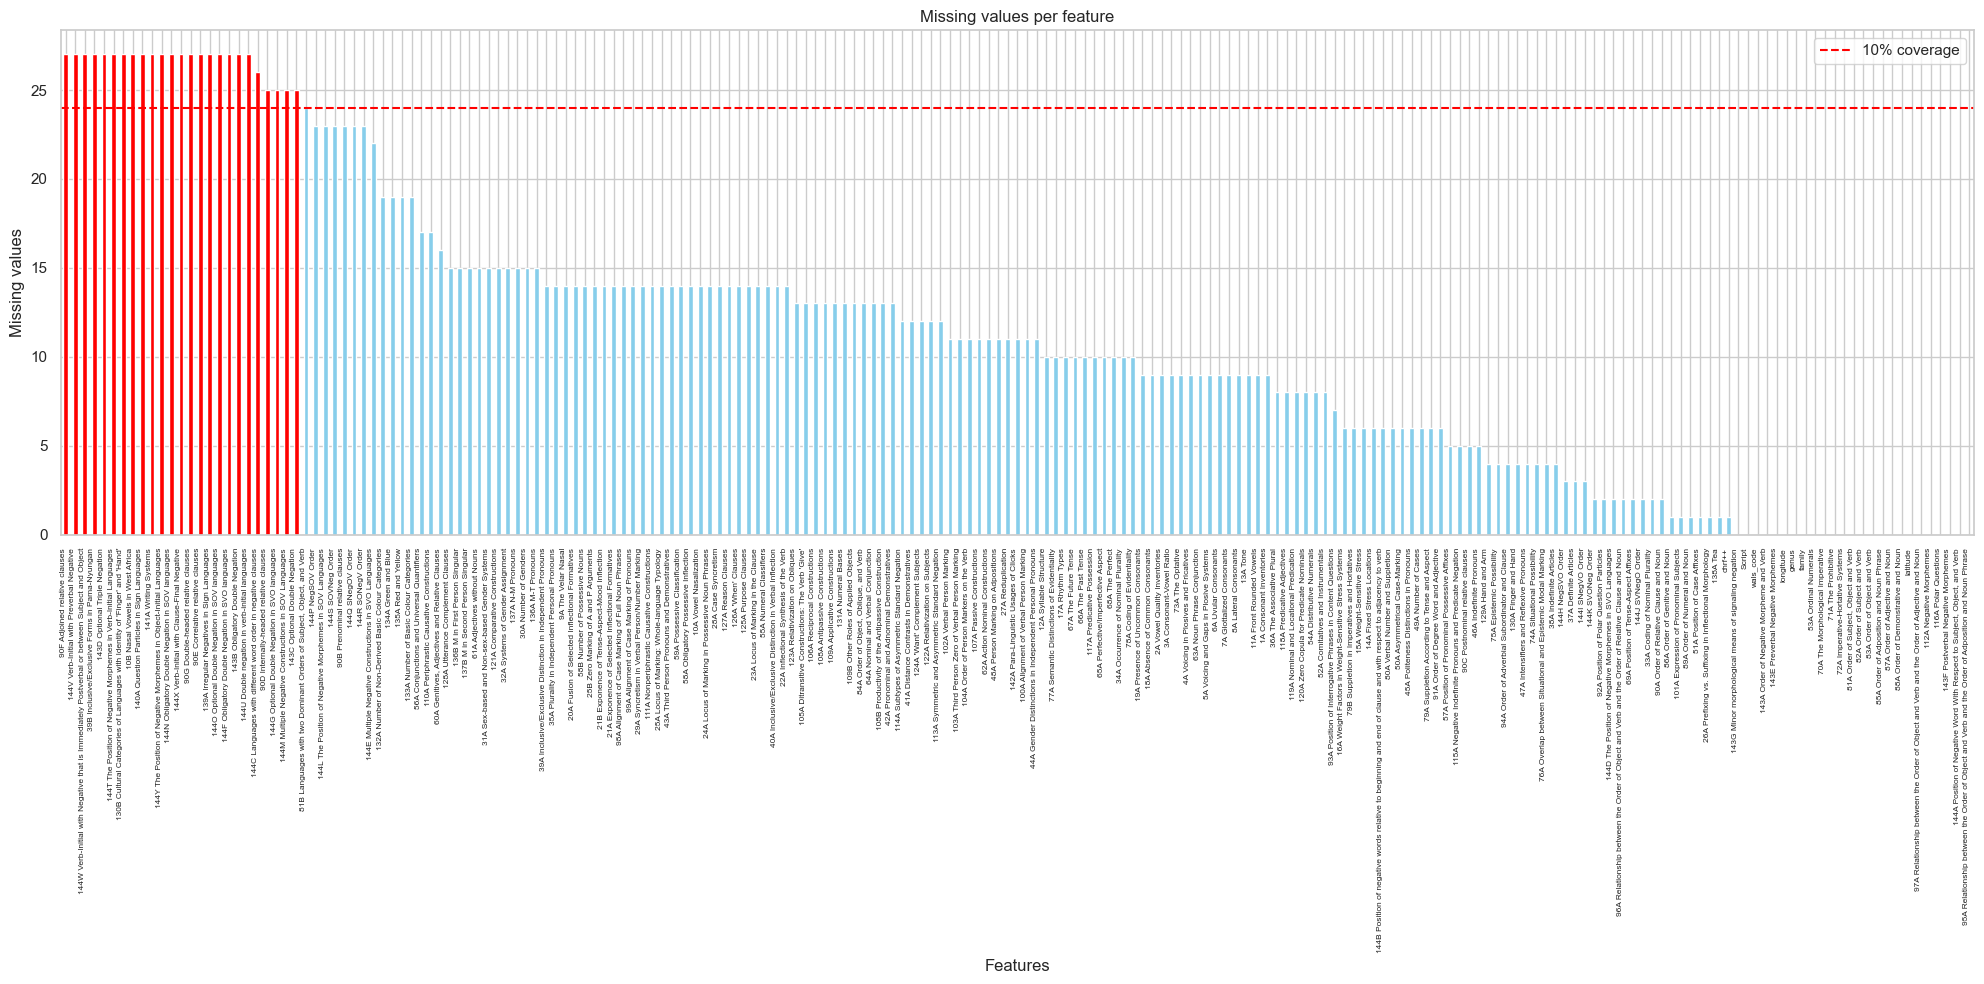

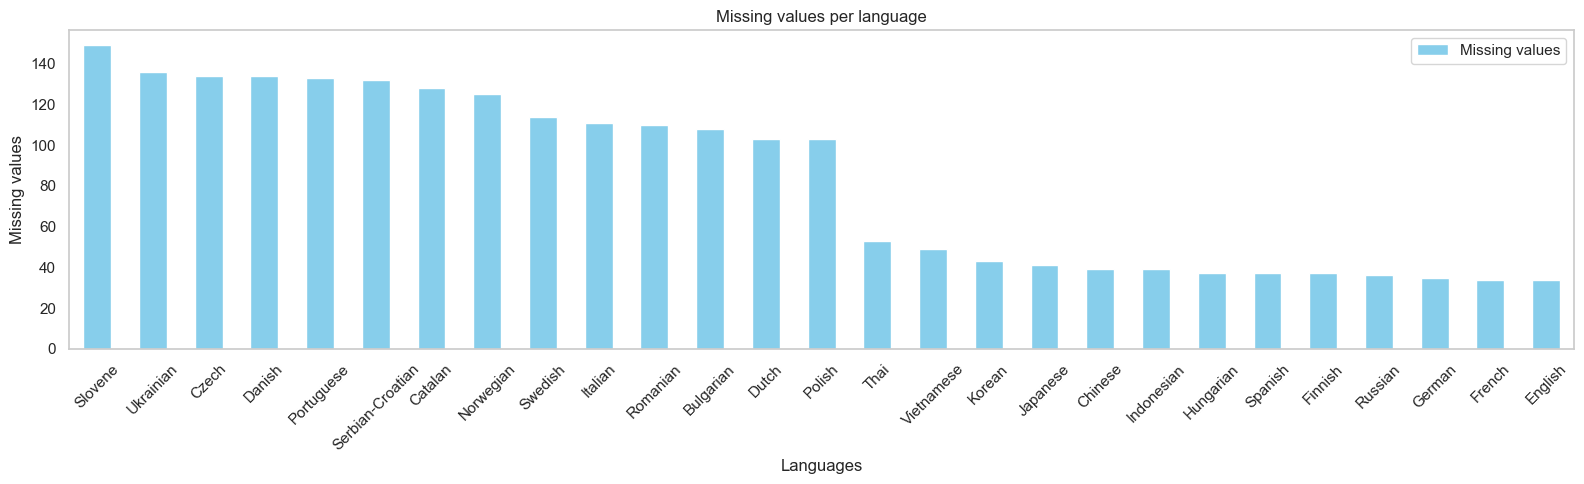

In [58]:
sns.set_theme(style="whitegrid")

# missing value per characteristic (column)
missing_values_features = walsdata_test.isnull().sum(axis=0)
missing_values_features = missing_values_features.sort_values(ascending=False)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

colors = ['red' if value > threshold else 'skyblue' for value in missing_values_features]

fig, ax = plt.subplots(figsize=(20, 10))
missing_values_features.plot(kind='bar', color=colors, ax=ax)

plt.axhline(y=threshold, color='red', linestyle='--', label='10% coverage')  

# # Customize x-tick labels
xticklabels = [label for label in missing_values_features.index]
# xticklabels = [label if value > threshold else '' for label, value in zip(missing_values.index, missing_values)]
ax.set_xticklabels(xticklabels, fontsize=6 ,ha='right')

# Optional: Hide x-tick labels completely if not needed
# ax.set_xticklabels([])

plt.title("Missing values per feature")
plt.ylabel("Missing values")
plt.xlabel("Features")

plt.tight_layout()
plt.legend()
plt.show()

sns.set_theme(style="whitegrid")

# missing value per language
missing_values_lang = pd.DataFrame({'Missing values' : walsdata_test.isnull().sum(axis=1)})
missing_values_lang = missing_values_lang.sort_values(by='Missing values', ascending=False)

fig, ax = plt.subplots(figsize=(16, 5))
missing_values_lang.plot(kind='bar', color='skyblue', ax=ax)

plt.title("Missing values per language")
plt.ylabel("Missing values")
plt.xlabel("Languages")
plt.xticks(rotation=45)
plt.grid(False)

plt.tight_layout()
plt.show()

In [59]:
# remove languages with <25 features filled
mask = walsdata_test.isnull().sum(axis=1) >= 25

removed1 = len(walsdata_test) - len(mask)

walsdata_test = walsdata_test[mask]

# remove features with <10% coverage
missing_values2 = walsdata_test.isnull().sum(axis=0)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

features_above_threshold = missing_values2[missing_values2 > threshold].index.tolist()

walsdata_test = walsdata_test.drop(columns=features_above_threshold)

removed2 = len(features_above_threshold)

print('Removed languages (<25 features):',removed1)
print('Removed features (<10% coverage):',removed2)

Removed languages (<25 features): 0
Removed features (<10% coverage): 25


In [60]:
#  removed features
print(missing_values_features.head(25))

90F Adjoined relative clauses                                                                   27
144V Verb-Initial with Preverbal Negative                                                       27
144W Verb-Initial with Negative that is Immediately Postverbal or between Subject and Object    27
39B Inclusive/Exclusive Forms in Pama-Nyungan                                                   27
143D Optional Triple Negation                                                                   27
144T The Position of Negative Morphemes in Verb-Initial Languages                               27
130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'                      27
10B Nasal Vowels in West Africa                                                                 27
140A Question Particles in Sign Languages                                                       27
141A Writing Systems                                                                            27
144Y The P

In [84]:
### feature groups
# genus = ['genus']
# family = ['family']
# script = ['Script']
# phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
# morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
# nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
# nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
# verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
# wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143B Obligatory Double Negation','143C Optional Double Negation','143D Optional Triple Negation','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144C Languages with different word order in negative clauses','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144F Obligatory Double Negation in SVO languages','144G Optional Double Negation in SVO languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144M Multiple Negative Constructions in SOV Languages','144N Obligatory Double Negation in SOV languages','144O Optional Double Negation in SOV languages','144P NegSOV Order','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order','144T The Position of Negative Morphemes in Verb-Initial Languages','144U Double negation in verb-initial languages','144V Verb-Initial with Preverbal Negative','144W Verb-Initial with Negative that is Immediately Postverbal or between Subject and Object','144X Verb-Initial with Clause-Final Negative','144Y The Position of Negative Morphemes in Object-Initial Languages']
# simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
# complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
# lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']
# other = ['141A Writing Systems','142A Para-Linguistic Usages of Clicks']

genus = ['genus']
family = ['family']
script = ['Script']
geo = ['longitude','latitude']
phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order']
simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']
other = ['142A Para-Linguistic Usages of Clicks']

In [98]:
len(verbal_cat)

16

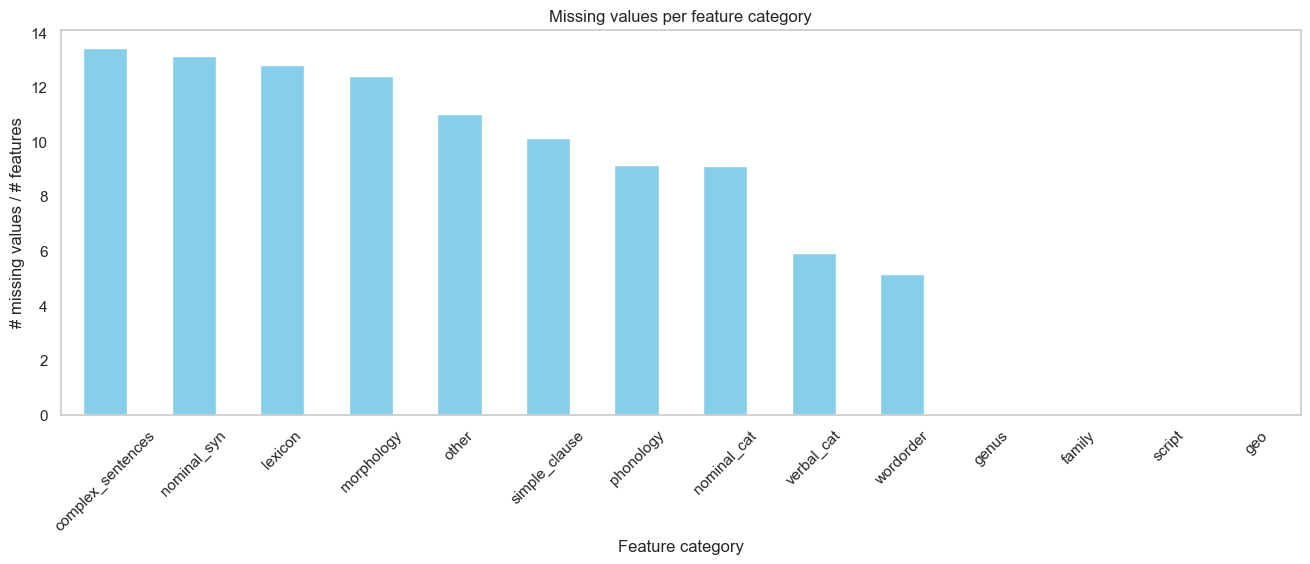

In [101]:
# of relatief tov totaal aantal features

missing_values_category = pd.DataFrame()
missing_values_category['genus'] = walsdata_test[genus].isnull().sum(axis=1) / len(genus)
missing_values_category['family'] = walsdata_test[family].isnull().sum(axis=1) / len(family)
missing_values_category['script'] = walsdata_test[script].isnull().sum(axis=1) / len(script)
missing_values_category['geo'] = walsdata_test[geo].isnull().sum(axis=1) / len(geo)
missing_values_category['phonology'] = walsdata_test[phonology].isnull().sum(axis=1) / len(phonology)
missing_values_category['morphology'] = walsdata_test[morphology].isnull().sum(axis=1) / len(morphology)
missing_values_category['nominal_cat'] = walsdata_test[nominal_cat].isnull().sum(axis=1) / len(nominal_cat)
missing_values_category['nominal_syn'] = walsdata_test[nominal_syn].isnull().sum(axis=1) / len(nominal_syn)
missing_values_category['verbal_cat'] = walsdata_test[verbal_cat].isnull().sum(axis=1) / len(verbal_cat)
missing_values_category['wordorder'] = walsdata_test[wordorder].isnull().sum(axis=1) / len(wordorder)
missing_values_category['simple_clause'] = walsdata_test[simple_clause].isnull().sum(axis=1) / len(simple_clause)
missing_values_category['complex_sentences'] = walsdata_test[complex_sentences].isnull().sum(axis=1) / len(complex_sentences)
missing_values_category['lexicon'] = walsdata_test[lexicon].isnull().sum(axis=1) / len(lexicon)
missing_values_category['other'] = walsdata_test[other].isnull().sum(axis=1) / len(other)
# missing_values_category['Total'] = missing_values_category[['genus','family','script','phonology','morphology','nominal_cat','nominal_syn','verbal_cat','wordorder','simple_clause','complex_sentences','lexicon','other']].sum(axis=1)

column_sums = missing_values_category.sum(axis=0)
column_sums = column_sums.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16, 5))
column_sums.plot(kind='bar',color='skyblue',ax=ax)

plt.title('Missing values per feature category')
plt.grid(False)
plt.xlabel('Feature category')
plt.ylabel('# missing values / # features')
plt.xticks(rotation=45) 
plt.show()

More on the datatype of each feature. Plus for feature groups missing values + ordinal/categorical + nr of features per group



In [102]:
walsdata_test[phonology].head()

1A Consonant Inventories 2A Vowel Quality Inventories  \
Name                                                              
Bulgarian                3 Average              2 Average (5-6)   
Catalan                  3 Average               3 Large (7-14)   
Czech                          NaN                          NaN   
Danish                         NaN                          NaN   
Dutch                          NaN                          NaN   

          3A Consonant-Vowel Ratio 4A Voicing in Plosives and Fricatives  \
Name                                                                       
Bulgarian                3 Average     4 In both plosives and fricatives   
Catalan                  3 Average     4 In both plosives and fricatives   
Czech                          NaN                                   NaN   
Danish                         NaN                                   NaN   
Dutch                          NaN                                   NaN   

          5A Voicing and Gaps in Plosive Systems 6A Uvular Consonants  \
Name                                                                    
Bulgarian        2 None missing in /p t k b d g/               1 None   
Catalan          2 None missing in /p t k b d g/               1 None   
Czech                                        NaN                  NaN   
Danish                                       NaN                  NaN   
Dutch                                        NaN                  NaN   

             7A Glottalized Consonants         8A Lateral Consonants  \
Name                                                                   
Bulgarian  1 No glottalized consonants  2 /l/, no obstruent laterals   
Catalan    1 No glottalized consonants  2 /l/, no obstruent laterals   
Czech                              NaN                           NaN   
Danish                             NaN                           NaN   
Dutch                              NaN                           NaN   

          9A The Velar Nasal 10A Vowel Nasalization 11A Front Rounded Vowels  \
Name                                                                           
Bulgarian                NaN                    NaN                   1 None   
Catalan                  NaN                    NaN                   1 None   
Czech                    NaN                    NaN                      NaN   
Danish                   NaN                    NaN                      NaN   
Dutch                    NaN                    NaN                      NaN   

          12A Syllable Structure    13A Tone 14A Fixed Stress Locations  \
Name                                                                      
Bulgarian              3 Complex  1 No tones                        NaN   
Catalan     2 Moderately complex  1 No tones          1 No fixed stress   
Czech                        NaN         NaN                  2 Initial   
Danish                       NaN         NaN          1 No fixed stress   
Dutch                        NaN         NaN          1 No fixed stress   

                       15A Weight-Sensitive Stress  \
Name                                                 
Bulgarian                                      NaN   
Catalan      3 Right-edge: Ultimate or penultimate   
Czech       8 Fixed stress (no weight-sensitivity)   
Danish        6 Combined: Right-edge and unbounded   
Dutch      4 Right-oriented: One of the last three   

          16A Weight Factors in Weight-Sensitive Stress Systems  \
Name                                                              
Bulgarian                                                NaN      
Catalan                                     6 Lexical stress      
Czech                                            1 No weight      
Danish                        4 Long vowel or coda consonant      
Dutch                                       3 Coda consonant      

               17A Rhythm Types 18A Absence of Common 

The features in the WALS dataset are mainly categorical and ordinal.

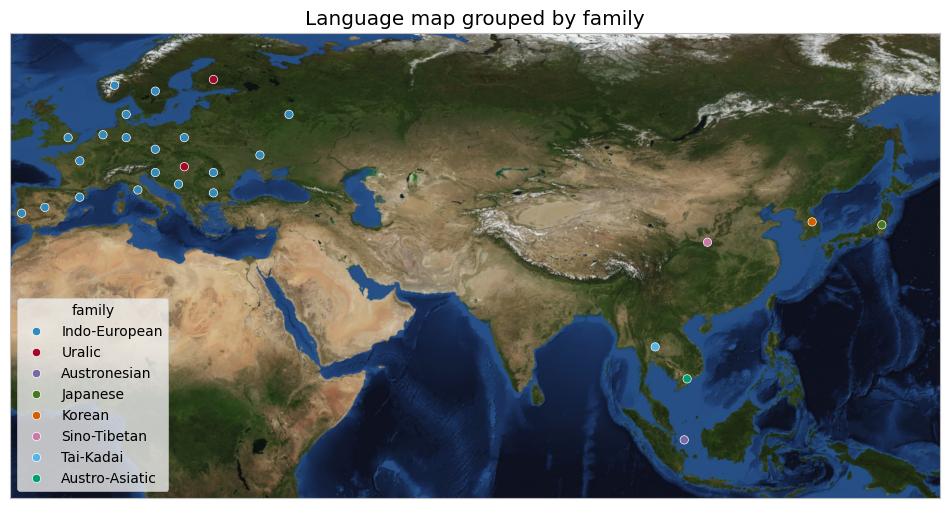

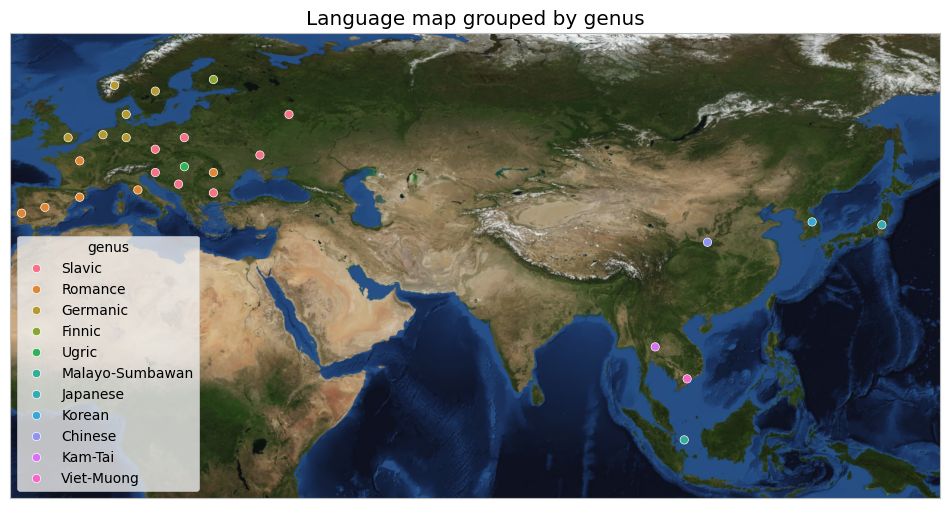

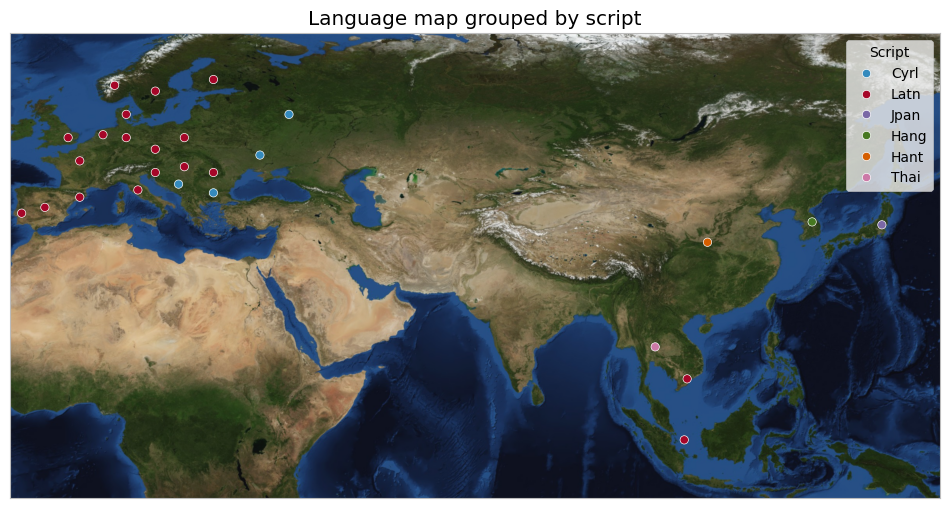

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='family', data =walsdata_test, legend=True)

plt.title("Language map grouped by family")
plt.show()

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='genus', data =walsdata_test, legend=True)

plt.title("Language map grouped by genus")
plt.show()

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='Script', data =walsdata_test, legend=True)

plt.title("Language map grouped by script")
plt.show()

In [ ]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

###### plots for family and genus

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="family", data=walsdata_test, order=walsdata_test['family'].value_counts().index, ax=axes[0], color='skyblue')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Family")
axes[0].set_title("Languages included in the experiment grouped by family")
# axes[0].set_xticks(range(0, 8, 1))

# Plot 2: Languages grouped by 'genus'
sns.countplot(y="genus", data=walsdata_test, order=walsdata_test['genus'].value_counts().index, ax=axes[1],color='skyblue')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Genus")
axes[1].set_title("Languages included in the experiment grouped by genus")
# axes[1].set_xticks(range(0, 8, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

###### plots for macroarea and script

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="macroarea", data=walsdata_test, order=walsdata_test['macroarea'].value_counts().index, ax=axes[0], color='skyblue')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Macroarea")
axes[0].set_title("Languages included in the experiment grouped by macroarea")
# axes[0].set_xticks(range(0, 8, 1))

# Plot 2: Languages grouped by 'script'
sns.countplot(y="Script", data=walsdata_test, order=walsdata_test['Script'].value_counts().index, ax=axes[1],color='skyblue')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Script")
axes[1].set_title("Languages included in the experiment grouped by script")
# axes[1].set_xticks(range(0, 8, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### References

1. Cobbe, K., Kosaraju, V., Bavarian, M., Chen, M., Jun, H., Kaiser, L., ... & Schulman, J. (2021). Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168.
2. Shi, F., Suzgun, M., Freitag, M., Wang, X., Srivats, S., Vosoughi, S., ... & Wei, J. (2022). Language models are multilingual chain-of-thought reasoners. arXiv preprint arXiv:2210.03057.
3. Qin, L., Chen, Q., Wei, F., Huang, S., & Che, W. (2023). Cross-lingual prompting: Improving zero-shot chain-of-thought reasoning across languages. arXiv preprint arXiv:2310.14799.
4. Huang, H., Tang, T., Zhang, D., Zhao, W. X., Song, T., Xia, Y., & Wei, F. (2023). Not All Languages Are Created Equal in LLMs: Improving Multilingual Capability by Cross-Lingual-Thought Prompting. arXiv preprint arXiv:2305.07004.
5. Ponti, E. M., Glavaš, G., Majewska, O., Liu, Q., Vulić, I., & Korhonen, A. (2020). XCOPA: A multilingual dataset for causal commonsense reasoning. arXiv preprint arXiv:2005.00333.
6. Roemmele, M., Bejan, C. A., & Gordon, A. S. (2011, March). Choice of plausible alternatives: An evaluation of commonsense causal reasoning. In 2011 AAAI Spring Symposium Series.
7. Dryer, Matthew S. & Haspelmath, Martin (eds.) 2013. WALS Online (v2020.3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7385533 (Available online at https://wals.info, Accessed on 2024-01-30.)
8. Unicode CLDR (2023). Languages and scripts. Retrieved from https://www.unicode.org/cldr/charts/44/supplemental/languages_and_scripts.html
9. Costa-jussà, M. R., Cross, J., Çelebi, O., Elbayad, M., Heafield, K., Heffernan, K., ... & NLLB Team. (2022). No language left behind: Scaling human-centered machine translation. arXiv preprint arXiv:2207.04672.
10. Touvron, H., Martin, L., Stone, K., Albert, P., Almahairi, A., Babaei, Y., ... & Scialom, T. (2023). Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288.
11. Muennighoff, N., Wang, T., Sutawika, L., Roberts, A., Biderman, S., Le Scao, T., ... & Raffel, C. Crosslingual Generalization through Multitask Finetuning, 2022. URL https://arxiv. org/abs/2211.01786.
12. Georgi, R., Xia, F., & Lewis, W. (2010, August). Comparing language similarity across genetic and typologically-based groupings. In Proceedings of the 23rd international conference on computational linguistics (Coling 2010) (pp. 385-393).